In [17]:
# import librarires
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pickle
from torchvision import models

import os
from custom_dataset import CustomDataset

In [18]:
def get_directories(path):
    # Get list of all files and directories in the given path
    contents = os.listdir(path)
    
    # Filter out only directories
    directories = [content for content in contents if os.path.isdir(os.path.join(path, content))]
    
    return directories

In [19]:
CATEGORIES = get_directories('./train')

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
train_data = pickle.load(open('./train_data.pickle', 'rb'))
val_data = pickle.load(open('./val_data.pickle', 'rb'))

In [39]:
new_train_data = CustomDataset(train_data)
new_val_data = CustomDataset(val_data)

In [40]:
cnn = models.resnet18(pretrained = True)
# weight
num_ftrs = cnn.fc.in_features # 512
print(num_ftrs)

c:\Users\andre\anaconda3\envs\leaf_cse120\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andre\anaconda3\envs\leaf_cse120\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


512


In [41]:

# Define your data loaders
train_loader = torch.utils.data.DataLoader(new_train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(new_val_data, batch_size=64, shuffle=False)

In [42]:
cnn.fc= nn.Linear(num_ftrs,len(CATEGORIES)) ## ??
cnn.to(device)
num_epochs = 10
# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.0001, momentum=0.9)




In [43]:
# # Train the model
# cnn.train()
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     correct = 0
#     total = 0
    
#     # Print current epoch
#     print(f"Epoch {epoch+1}/{num_epochs}")
    
#     # Iterate over the training dataset
#     for i, (inputs, labels) in enumerate(train_loader, 1):
#         # Move data to the appropriate device (GPU if available)
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         optimizer.zero_grad()
#         inputs = inputs.float() / 255.0  # Convert inputs to float format
#         outputs = cnn(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, predicted = outputs.max(1)
#         total += labels.size(0)
#         correct += predicted.eq(labels).sum().item()
        
#         # Print progress every 100 mini-batches
#         if i % 100 == 0:
#             print(f"Mini-batch {i}/{len(train_loader)}, Loss: {loss.item():.3f}, Accuracy: {(100*correct/total):.2f}%")

#     # Print average loss and accuracy for the epoch
#     print(f"Epoch {epoch+1} - Average Loss: {running_loss/len(train_loader):.3f}, Accuracy: {(100*correct/total):.2f}%")

In [44]:
# # Validate the model
# cnn.eval()
# val_correct = 0
# val_total = 0
# with torch.no_grad():
#     for inputs, labels in val_loader:
#         inputs = inputs.float() / 255.0
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = cnn(inputs)
#         _, predicted = outputs.max(1)
#         val_total += labels.size(0)
#         val_correct += predicted.eq(labels).sum().item()

# print(f"Validation Accuracy: {(100*val_correct/val_total):.2f}%")

In [45]:
# Initialize lists to store training and validation losses
train_losses = []
val_losses = []
conf_matrices = []

# Train the model
cnn.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Print current epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Iterate over the training dataset
    for i, (inputs, labels) in enumerate(train_loader, 1):
        # Move data to the appropriate device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        #inputs = inputs.float() / 255.0  # Convert inputs to float format
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Print progress every 100 mini-batches
        if i % 100 == 0:
            print(f"Mini-batch {i}/{len(train_loader)}, Loss: {loss.item():.3f}, Accuracy: {(100*correct/total):.2f}%")

    # Compute average training loss for the epoch
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Print average loss and accuracy for the epoch
    print(f"Epoch {epoch+1} - Average Loss: {train_loss:.3f}, Accuracy: {(100*correct/total):.2f}%")

    # Validate the model
    cnn.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_predicted = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            #inputs = inputs.float() / 255.0
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = cnn(inputs)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            
            # Append predictions and labels for confusion matrix
            val_predicted.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Compute and print validation loss for the epoch
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.3f}")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(val_labels, val_predicted)
    conf_matrices.append(conf_matrix)

# Accumulate confusion matrices
accumulated_conf_matrix = sum(conf_matrices)

Epoch 1/10
Epoch 1 - Average Loss: 2.313, Accuracy: 10.00%
Validation Loss: 2.544
Epoch 2/10
Epoch 2 - Average Loss: 2.430, Accuracy: 0.00%
Validation Loss: 2.555
Epoch 3/10
Epoch 3 - Average Loss: 2.391, Accuracy: 0.00%
Validation Loss: 2.575
Epoch 4/10
Epoch 4 - Average Loss: 2.324, Accuracy: 0.00%
Validation Loss: 2.605
Epoch 5/10
Epoch 5 - Average Loss: 2.234, Accuracy: 10.00%
Validation Loss: 2.648
Epoch 6/10
Epoch 6 - Average Loss: 2.127, Accuracy: 20.00%
Validation Loss: 2.704
Epoch 7/10
Epoch 7 - Average Loss: 2.010, Accuracy: 30.00%
Validation Loss: 2.774
Epoch 8/10
Epoch 8 - Average Loss: 1.887, Accuracy: 50.00%
Validation Loss: 2.858
Epoch 9/10
Epoch 9 - Average Loss: 1.766, Accuracy: 50.00%
Validation Loss: 2.951
Epoch 10/10
Epoch 10 - Average Loss: 1.653, Accuracy: 50.00%
Validation Loss: 3.053


ValueError: operands could not be broadcast together with shapes (8,8) (9,9) 

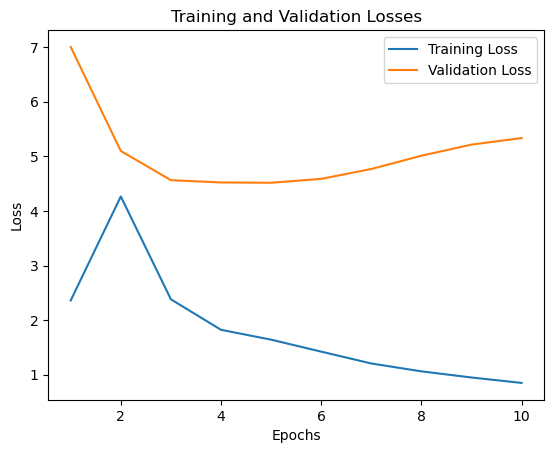

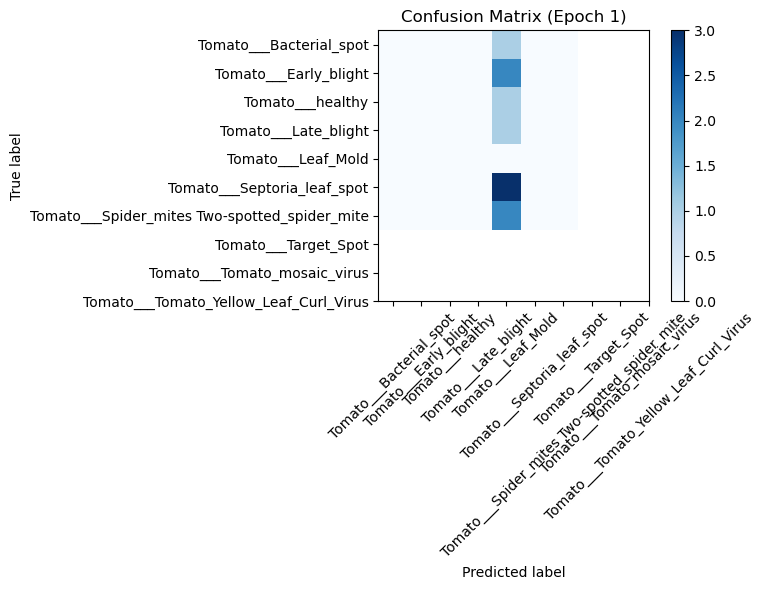

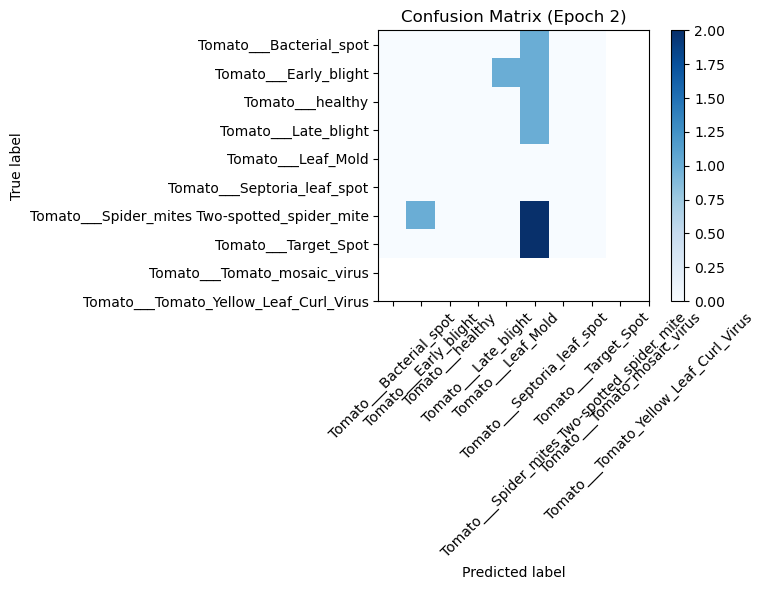

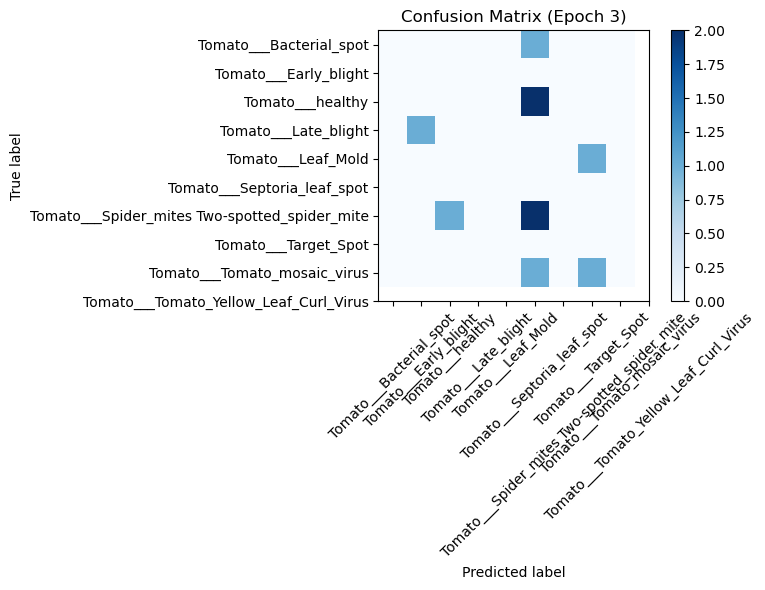

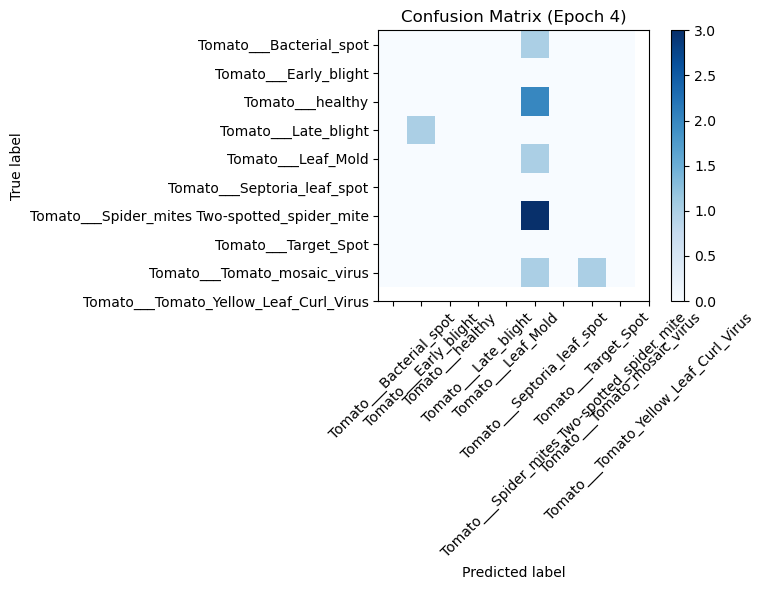

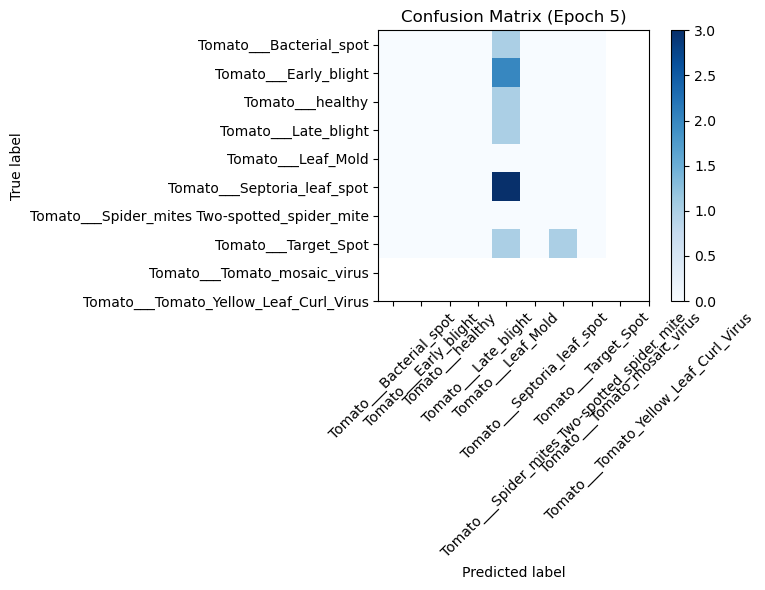

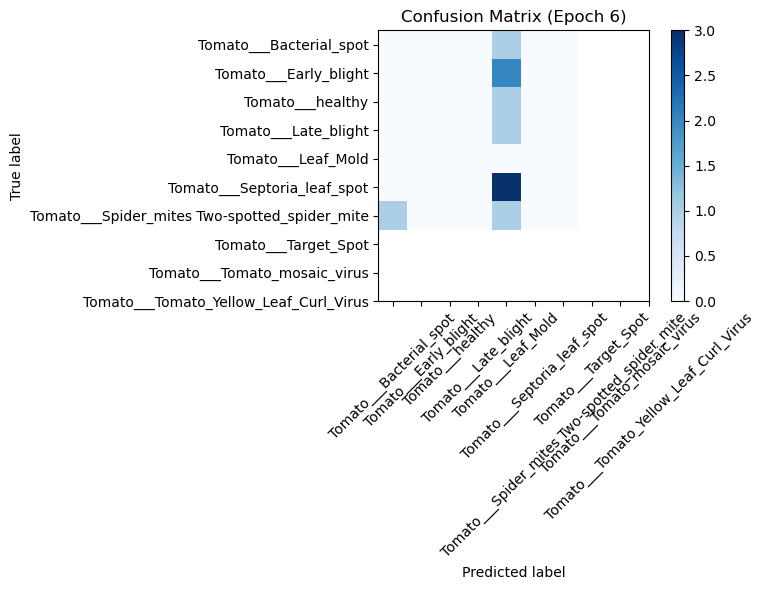

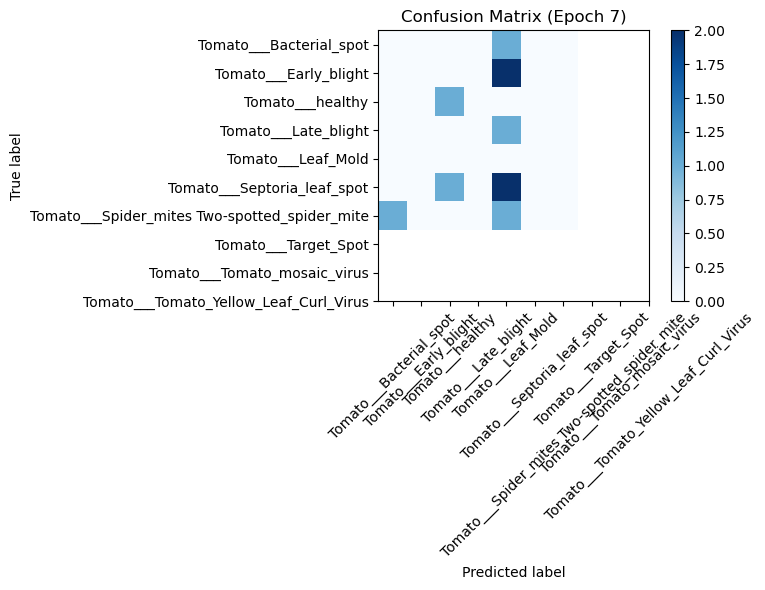

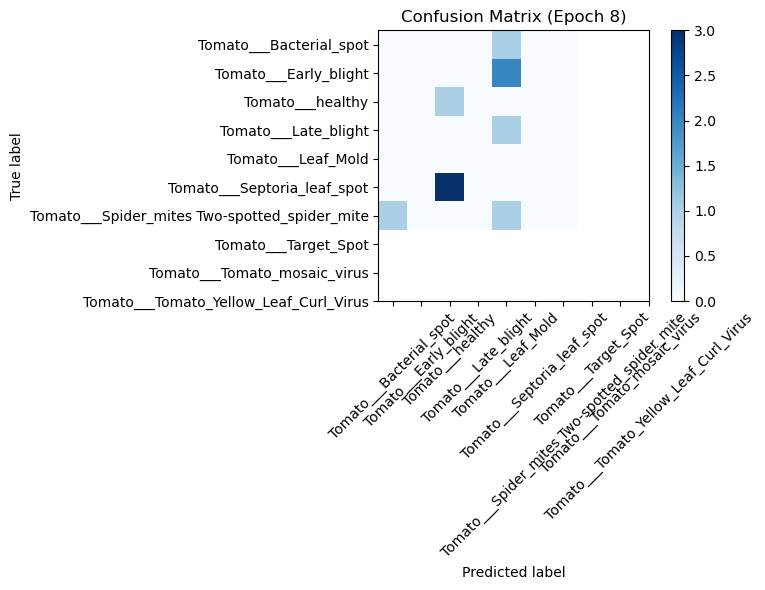

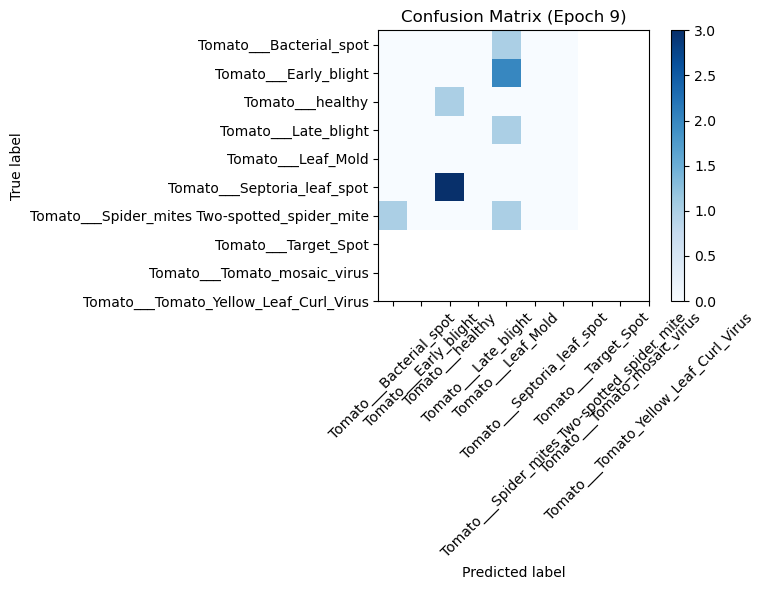

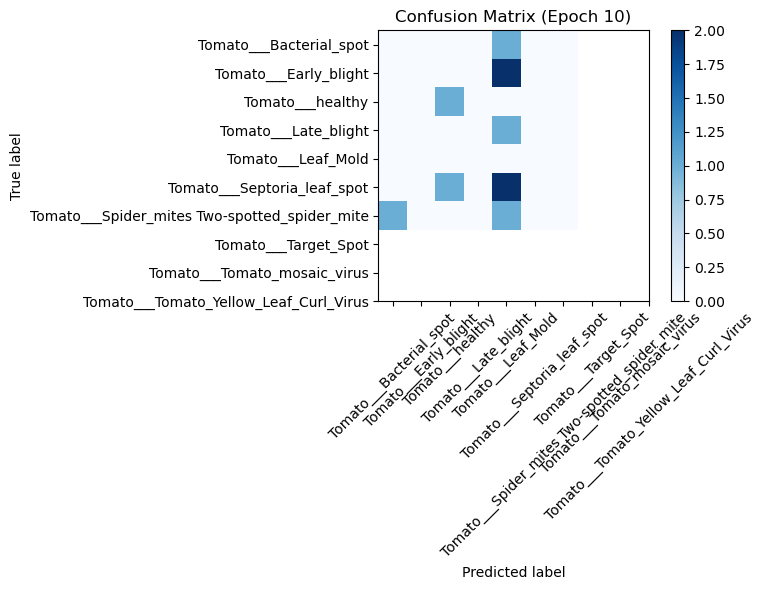

In [ ]:
# Define your class labels and total pictures here
classes = [
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___healthy',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]


# Plot training and validation losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plot confusion matrices
for epoch, conf_matrix in enumerate(conf_matrices, 1):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (Epoch {epoch})')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>